# Interpretation precision metric - Single shot detector (SSD)


In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Necessary imports and load SSD-tensorflow

In [2]:
import math
import random
import json
import datetime
import getopt
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image

slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
import os
sys.path.append('models/SSD-Tensorflow') #os.path.join(os.path.dirname(os.path.abspath(__file__)), 
sys.path.append('models/SSD-Tensorflow/notebooks')
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
import visualization

In [3]:
# LOAD SSD
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
graph = tf.Graph()
graph.as_default()
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.Session(config=config)

# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, logits, endpoints = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = 'models/SSD-Tensorflow/checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from models/SSD-Tensorflow/checkpoints/ssd_300_vgg.ckpt


## Function to run ssd prediction for an image

In [4]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    #plt.imshow(ssd_vgg_preprocessing.np_image_unwhitened(rimg[0]))
    #plt.show()
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes, l_layers, l_idxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)

    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes, l_idxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, l_idxes, top_k=400)
    rclasses, rscores, rbboxes, l_idxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, l_idxes, nms_threshold=nms_threshold)

    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    l_idxes = [(i, (0,)+np.unravel_index(idx[1], rpredictions[i].shape[1:-1])+(idx[-1]+1,)) for i, idx in l_idxes]
    return rclasses, rscores, rbboxes, l_idxes, rimg

## Function to read images from VOC dataset and segmentation ground truth

In [5]:
def read_image_and_segmentation_ground_truth(path_to_VOC, voc_name):
    if len(voc_name):
        image_path = path_to_VOC + 'JPEGImages/' + voc_name + '.jpg'
        segmentation_path = path_to_VOC + 'SegmentationClass/' + voc_name + '.png'
        segmentation_object_path = path_to_VOC + 'SegmentationObject/' + voc_name + '.png'
    else:
        raise NotImplementedError
    segmentation_img = Image.open(segmentation_path)
    segmentation = np.array(list(segmentation_img.getdata()))
    segmentation = np.reshape(segmentation, (segmentation_img.size[1], segmentation_img.size[0]))

    segmentation_object_img = Image.open(segmentation_object_path)
    segmentation_object = np.array(list(segmentation_object_img.getdata()))
    segmentation_object = np.reshape(segmentation_object, (segmentation_object_img.size[1], segmentation_object_img.size[0]))
    number_of_objects_segmentation = np.max(segmentation_object[segmentation_object < 255])

    img = mpimg.imread(image_path)
    img.setflags(write = 1)

    assert img.shape[:2] == segmentation.shape
    masks = np.zeros([number_of_objects_segmentation]+list(img.shape[:2]))
    masks = masks.astype(bool)
    class_of_object = {}
    segmentation_bboxes = []
    height = img.shape[0]
    width = img.shape[1]

    for object_number in range(1, number_of_objects_segmentation+1):
        object_idx = object_number - 1
        masks[object_idx] = segmentation_object == object_number
        assert np.max(segmentation[masks[object_idx]]) == np.min(segmentation[masks[object_idx]])
        class_of_object[object_idx] = np.max(segmentation[masks[object_idx]])
        xmin = float(np.min(np.where(masks[object_idx])[0])) / height
        ymin = float(np.min(np.where(masks[object_idx])[1])) / width
        xmax = float(np.max(np.where(masks[object_idx])[0])) / height
        ymax = float(np.max(np.where(masks[object_idx])[1])) / width
        segmentation_bboxes.append([xmin, ymin, xmax, ymax])
    print('number_of_objects_segmentation', number_of_objects_segmentation)
    return img, number_of_objects_segmentation, class_of_object, segmentation_bboxes, masks

In [6]:
VOC_LABELS = [
    'none',
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor',
    ]

## Loading an example image and its semantic segmentation

In [7]:
# read inputs
img, number_of_objects_segmentation, class_of_object, segmentation_bboxes, masks = read_image_and_segmentation_ground_truth('data/VOC_examples/VOC2012/', '2007_003503')

number_of_objects_segmentation 5


## Running SSD detection on the image

[11 12  8 14 13  2  9  3  4  6 10  5 15  0  1  7]
objects detected in original image 4


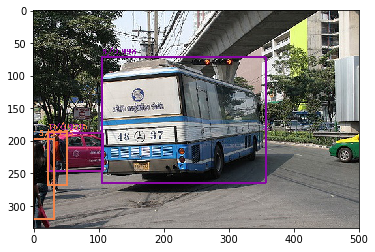

In [8]:
#detect original image
original_classes, original_scores, original_bboxes, original_idxes, preprocessed_img = process_image(img)
img_bboxes = np.copy(img)
preprocessed_img_bboxes = ssd_vgg_preprocessing.np_image_unwhitened(preprocessed_img[0])
visualization.bboxes_draw_on_img(img_bboxes, original_classes, original_scores, original_bboxes, visualization.colors_plasma)
visualization.bboxes_draw_on_img(preprocessed_img_bboxes, original_classes, original_scores, original_bboxes, visualization.colors_plasma)
#basename = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S_')

plt.imshow(img_bboxes)
print('objects detected in original image', len(original_classes))

In [9]:
from nndependability.metrics import InterpretationMetric


## Computing heatmap or saliency map

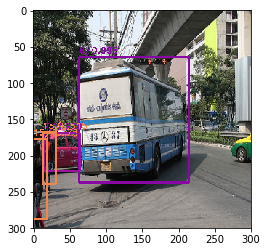

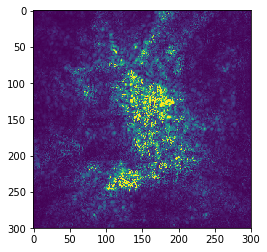

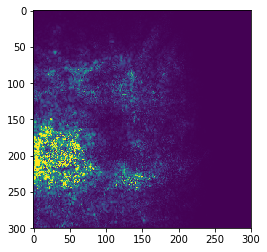

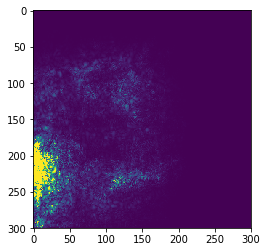

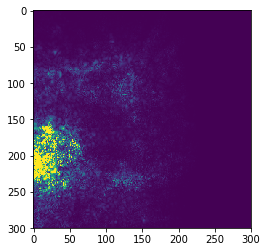

In [10]:
#compute heatmap or saliency
mode = 'SALIENCY'
if mode == 'HEATMAP':
    heatmaps = compute_heatmaps(original_classes, original_bboxes, stride, img)
elif mode == 'SALIENCY':
    plt.imshow(preprocessed_img_bboxes)
    plt.show()
    heatmaps = []
    for i, idx in original_idxes:
        # performance='fast' for fast result of GradientSaliency
        # performance='precise' for more precise results of IntegratedGradient and Smoothed mask, but it is too slow for demo in notebook
        saliency_map = InterpretationMetric.compute_saliency(
            graph, isess, logits[i][idx], image_4d, preprocessed_img[0], performance='fast')
        heatmaps.append(saliency_map)
        
        plt.imshow(saliency_map)
        plt.show()

    np.concatenate(heatmaps)
else:
    raise NotImplementedError

## Computing interpretation precision metric

segmentation ground truth 1 of 4 bus


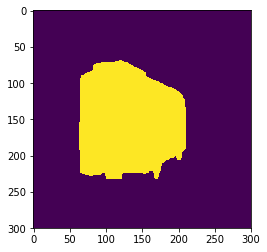

segmentation ground truth 2 of 4 car


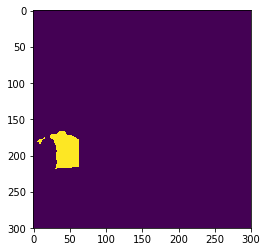

segmentation ground truth 3 of 4 person


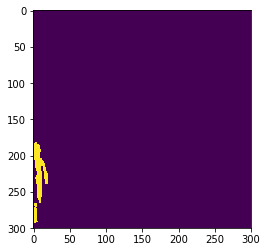

segmentation ground truth 4 of 4 person


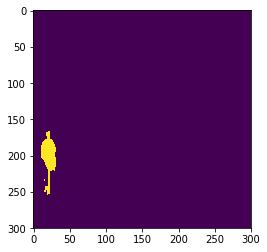

In [11]:
#compute metrics
metrics = {'number_of_boxes': len(original_classes)}
for idx, original_class in enumerate(original_classes):
    save_heatmap = Image.fromarray((heatmaps[idx]*255).astype(np.uint8))
    #save_heatmap.save(heatmap_path + basename + voc_name + '_heatmap_box_'+ str(idx) +'.png')
    
    #calculate metric
    #find ground truth object for this object, max iou of segmentation bbox with our bbox
    ious = np.array([InterpretationMetric.iou(segmentation_bbox, original_bboxes[idx]) for segmentation_bbox in segmentation_bboxes])
    object_idx_max_iou = np.argmax(ious)
    if class_of_object[object_idx_max_iou] == original_class:
    #compute metric here
        print('segmentation ground truth',idx+1,'of',len(original_classes), VOC_LABELS[original_class])
        m = InterpretationMetric.compute_metric(heatmaps[idx], masks[object_idx_max_iou], mode)

        metrics['box_'+ str(idx)] = {'metrics': m, 'bbox': original_bboxes[idx].tolist()}
    else:
        print('best overlapping box from segmentation has different class')

## Visualizing the results

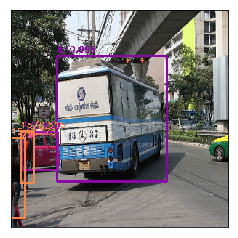

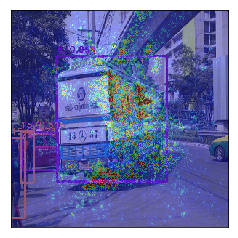

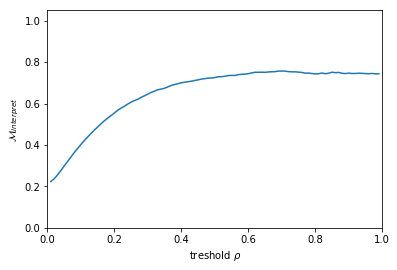

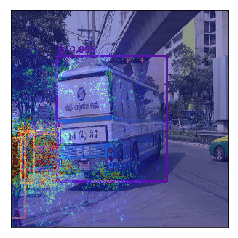

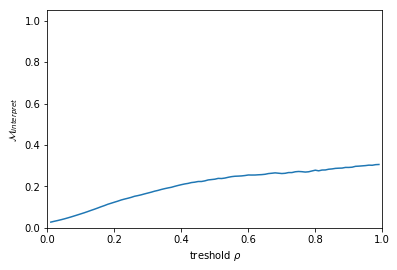

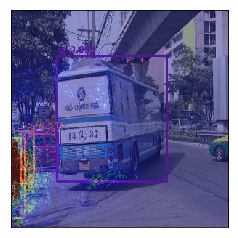

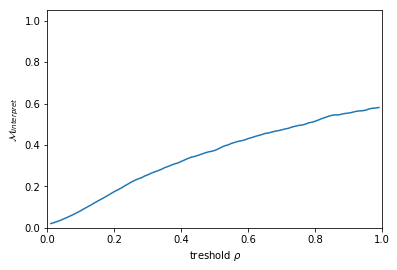

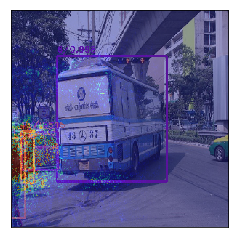

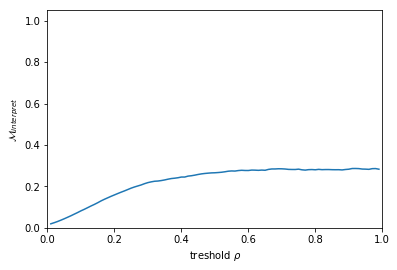

In [13]:
number_of_boxes = metrics['number_of_boxes']
img_bboxes = preprocessed_img_bboxes #mpimg.imread(image_bbox_path)

hot_tresholds = [0.01*float(x) for x in range(1,100)]
if mode=='SALIENCY':
    stride = 0
if stride > 0:
    grey_box_x = 100
    grey_box_y = 100
    [offset_x, offset_y] = [(x % stride) // 2 for x in img.shape[:2]]
    extent = 0, img.shape[1], 0, img.shape[0]
    extent_heatmap = offset_y, img.shape[1] - offset_y, offset_x, img.shape[0] - offset_x

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.imshow(img_bboxes)
plt.show()

for i in range(number_of_boxes):
    heatmap = heatmaps[i]

    if stride > 0:
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        plt.imshow(img, extent=extent, alpha=.9)
        cmap = plt.get_cmap('jet_r')
        plt.imshow(heatmap, extent=extent_heatmap, alpha=.4, cmap=cmap)
        plt.show()
    else:
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        plt.imshow(img_bboxes, alpha=.9)
        cmap = plt.get_cmap('jet')
        plt.imshow(heatmap, alpha=.4, cmap=cmap)
        plt.show()


    if 'box_'+str(i) not in metrics:
        continue
    plt.ylim(0,1.05)
    plt.xlim(0,1)
    plt.xlabel(r'treshold $\rho$')
    plt.ylabel(r"$\mathcal{M}_{interpret}$")
    plt.plot(hot_tresholds, metrics['box_'+str(i)]['metrics'][1:])
    plt.show()